# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from google.colab import files
import os
import warnings
import pickle
import json
from google.colab import drive

warnings.filterwarnings("ignore")
%matplotlib inline

# Bootstrap

In [2]:
import os
from dotenv import load_dotenv

# Find and load the .env file from the current or parent directories
load_dotenv()

# Access the environment variable using os.getenv()
PROJECT_PATH = os.getenv('PROJECT_PATH')
CONFIG_FILE = f"{PROJECT_PATH}/src/config.json"

In [3]:
drive.mount('/content/drive')

with open(CONFIG_FILE, 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
np.random.seed(31071967)

#[Download dataset from Kaggle](https://www.kaggle.com/datasets/joebeachcapital/30000-spotify-songs?select=spotify_songs.csv)

In [5]:
import os
import json
import subprocess

KAGGLE_DATAFILE="/content/spotify_data/spotify_songs.csv"

# STEP 1: check if dataset exists
if not os.path.exists(KAGGLE_DATAFILE):
    print("Downloading Spotify dataset from Kaggle...")

    # STEP 2: create API key file ~/.kaggle/kaggle.json
    subprocess.run(["pip", "install", "-q", "kaggle"])
    os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

    kaggle_config = {
        "username": os.getenv('KAGGLE_USERNAME'),
        "key": os.getenv('KAGGLE_API_KEY')
    }
    kaggle_json_path = os.path.expanduser("~/.kaggle/kaggle.json")
    with open(kaggle_json_path, "w") as f:
        json.dump(kaggle_config, f)
    os.chmod(kaggle_json_path, 0o600)

    # STEP 3: download dataset
    subprocess.run(["kaggle", "datasets", "download", "-d", "joebeachcapital/30000-spotify-songs"])

    # STEP 4: unzip the dataset
    subprocess.run(["unzip", "-o", "30000-spotify-songs.zip", "-d", "spotify_data"])

    # STEP 5: list the files
    subprocess.run(["ls", "spotify_data"])

    # STEP 6: remove the zip file
    os.remove("30000-spotify-songs.zip")

else:
    print("Spotify dataset already exists.")

#Upload dataset with Pandas

In [6]:
import pandas as pd
df = pd.read_csv(KAGGLE_DATAFILE)
display(df.head(1)), display(df.tail(1))

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.102,0.0,0.0653,0.518,122.036,194754


,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
32832,29zWqhca3zt5NsckZqDf6c,Typhoon - Original Mix,Julian Calor,27,0X3mUOm6MhxR7PzxG95rAo,Typhoon/Storm,2014-03-03,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,5,-4.571,0,0.0385,0.000133,0.341,0.742,0.0894,127.984,337500


(None, None)

In [7]:
# # appearnatly, five tracks appaers twice (different track_ids), each time in a different playlist. Even popularity is not identical.
# # decition: keep both copies
# duplicates = (df.groupby(['track_name', 'track_artist', 'track_album_id']).filter(lambda x: x['track_id'].nunique() > 1))
# duplicates = duplicates.sort_values(['track_artist', 'track_name', 'track_album_id'])

In [8]:
unique_id_cols = ['track_name']
dup_cols       = ['track_album_name', 'playlist_name','playlist_genre','instrumentalness']
large_cat_cols = ['track_artist', 'track_album_id', 'playlist_id']
small_cat_cols = ['mode','key', 'playlist_subgenre']
cont_cols      = ['acousticness', 'danceability','duration_ms','energy', 'liveness', 'loudness', 'speechiness', 'tempo','valence']
date_cols      = ['release_date']
cat_cols       = large_cat_cols + small_cat_cols
y_col          = 'track_popularity'
MERGE_ON_COL   = 'track_id' # if we'll need to merge pickels later

#Flatfile

In [9]:
def write_flat_file(df, filename):
  writer = pd.ExcelWriter(filename, engine="openpyxl")

  df.head().to_excel(writer, sheet_name='head')
  df.tail().to_excel(writer, sheet_name='tail')
  df.describe().to_excel(writer, sheet_name='describe')
  df.dtypes.to_excel(writer, sheet_name='data_type')
  df.select_dtypes(include=np.number).max().to_excel(writer, sheet_name='max - numeric columns')
  df.select_dtypes(include=np.number).min().to_excel(writer, sheet_name='min - numeric columns')
  df.isnull().sum(axis=0).to_excel(writer, sheet_name='NA')
  df.nunique().to_excel(writer, sheet_name='unique')

  writer.close()
  print(f"Flat file: {filename}")

flat_file = "spotify_flatfile.xlsx"
write_flat_file(df, f"{PROJECT_PATH}{project_config['pickles_directory']}{flat_file}")

Flat file: /content/drive/MyDrive/Projects/GitHub/Spotify/pickles/spotify_flatfile.xlsx


In [10]:
if project_config['split_df'] == '1':
  from sklearn.model_selection import train_test_split

  # split to avoid data leakage
  train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

  # keep the name df for code compliaency
  df = train_df
  del train_df

  # just a mark
  df['set']  = 'train'
  test_df['set']  = 'test'

else:
  test_df = None

In [11]:
def pickle_col(df, col='all', drop_col=False, include_merge_ID=True, pickle_name=""):

  import pickle

  if pickle_name == "":
    file_name = f"{PROJECT_PATH}{project_config['pickles_directory']}{col}.pkl"
  else:
    file_name = f"{PROJECT_PATH}{project_config['pickles_directory']}{pickle_name}.pkl"

  with open(file_name, 'wb') as f:

    if col =='all':
      pickle.dump(df, f)

    elif col in df.columns: # in case we aready droped the col before

      # track_id for a later merge, if we need.
      #and y_col so can can invetigate the pickel later indepandantly from the main df
      pickle.dump(df[[MERGE_ON_COL, col, y_col]], f)

    f.close()

    if drop_col == True:
      df.drop(col, axis=1, inplace=True, errors='ignore')

  if project_config['split_df'] == '1':
    with open(file_name+".test.pkl", 'wb') as f:

      if col =='all':
        pickle.dump(test_df, f)

      elif col in test_df.columns: # in case we aready droped the col before
        pickle.dump(test_df[[MERGE_ON_COL, col, y_col]], f)

      f.close()

    if drop_col == True:
      test_df.drop(col, axis=1, inplace=True, errors='ignore')

  return df

In [12]:
def apply_cat_mean_as_target_encode(train_df, cat_cols, encode_cols, target_col, test_df=None):

  for i in range(len(cat_cols)):
    train_means = train_df.groupby(cat_cols[i])[target_col].mean()
    train_df[encode_cols[i]] = train_df[cat_cols[i]].map(train_means).astype(float)

    if test_df is not None:
        test_means = test_df.groupby(cat_cols[i])[target_col].mean()
        test_df[encode_cols[i]] = test_df[cat_cols[i]].map(test_means).astype(float)
      #test_df[encode_cols[i]] = test_df[cat_cols[i]].map(train_means).astype(float)
      #test_df[encode_cols[i]].fillna(train_means, inplace=True)

# Dates

In [13]:
#track_album_release_date
if "track_album_release_date" in df.columns: # maybe I'm just rerunnig this cell


  df.track_album_release_date = pd.to_datetime(df.track_album_release_date, format='mixed')
  df['release_month' ] = df['track_album_release_date'].dt.month.astype(int)
  df['release_year'  ] = df['track_album_release_date'].dt.year.astype(int)
  df['release_decade'] = ((df['release_year'] // 10) * 10).astype(int)

  if project_config['split_df'] == '1':

    test_df.track_album_release_date = pd.to_datetime(test_df.track_album_release_date, format='mixed')
    test_df['release_month' ] = test_df['track_album_release_date'].dt.month.astype(int)
    test_df['release_year'  ] = test_df['track_album_release_date'].dt.year.astype(int)
    test_df['release_decade'] = ((test_df['release_year'] // 10) * 10).astype(int)

  apply_cat_mean_as_target_encode(
      df,
      cat_cols=['release_decade', 'release_month','release_year'],
      encode_cols=['release_decade_mean_popularity','release_month_mean_popularity','release_year_mean_popularity'],
      target_col='track_popularity',
      test_df=test_df)

  pickle_col(df, col="track_album_release_date", drop_col=True)

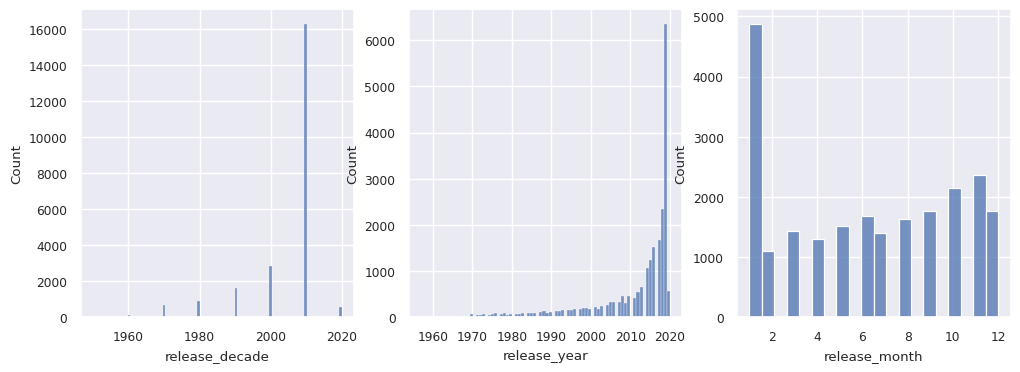

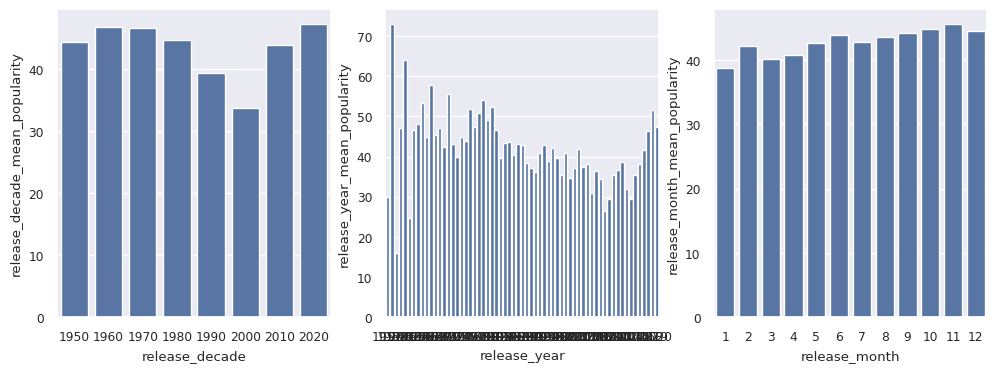

In [14]:
plot_columns = 3
plot_rows = 2

fig = plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace=1.0)
sb.set(font_scale=0.8)

for plot_counter, col in enumerate(['release_decade','release_year', 'release_month'],start=1):
    plt.subplot(plot_rows, plot_columns, plot_counter)
    sb.histplot(x=col, data=df)
plt.show()

fig = plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace=1.0)
sb.set(font_scale=0.8)

for plot_counter, col in enumerate(['release_decade','release_year', 'release_month'],start=1):
    plt.subplot(plot_rows, plot_columns, plot_counter)
    sb.barplot(x=col, y=f"{col}_mean_popularity", data=df)

plt.show()

# Categories

Uniqe IDs: **drop** to a pickel. Keeping track_id col with each pickel for possible merges later

Duplications (album_name, album_id, genre): **drop** to a pickel

Lerge cat cols: **replace** with the 'mean' popularity of each category - making it a continuence variabe on

Small cat cols: **group** categories based on ANOVA-tests between mean popoularity of each cat. **Replace** with with the 'mean' popularity of each category.

In [15]:
# unique ids and duplicaitons: drop
for col in unique_id_cols + dup_cols:
  df = pickle_col(df, col=col, drop_col=True)

In [16]:
# musical mode
df['mode'] = df['mode'].map({0: "Minor", 1: "Major"}).astype('string')

if project_config['split_df'] == '1':
  test_df['mode'] = test_df['mode'].map({0: "Minor", 1: "Major"}).astype('string')

In [17]:
# 12 categories for musical keys is small enoght to keep
# Mapping key-numbers into musical symbols, simpply for a better visualizalizaiton

musical_key_dict = {
    0: "C",
    1: "C♯/D♭",
    2: "D",
    3: "D♯/E♭",
    4: "E",
    5: "F",
    6: "F♯/G♭",
    7: "G",
    8: "G♯/A♭",
    9: "A",
    10: "A♯/B♭",
    11: "B"
}
if df['key'].dtype == 'int64': # or maybe I'm just rerunnig this cell

  df['key'] = df['key'].map(musical_key_dict).astype('string')

  if project_config['split_df'] == '1':
    test_df['key'] = test_df['key'].map(musical_key_dict).astype('string')


In [18]:
# using ANOVA for grouping 24 musical genres into 9

genre_map = {

    'post-teen pop'     : 'Teen Pop',
    'permanent wave'    : 'New Wave',

    'hip pop'           : 'Mainstream Pop & Hip-Hop',
    'hip hop'           : 'Mainstream Pop & Hip-Hop',
    'dance pop'         : 'Mainstream Pop & Hip-Hop',
    'reggaeton'         : 'Mainstream Pop & Hip-Hop',

    'latin pop'         : 'Latin & Urban Trap',
    'urban contemporary': 'Latin & Urban Trap',
    'trap'              : 'Latin & Urban Trap',

    'pop edm'           : 'Electro/Latin Pop Fusion',
    'latin hip hop'     : 'Electro/Latin Pop Fusion',
    'tropical'          : 'Electro/Latin Pop Fusion',
    'electropop'        : 'Electro/Latin Pop Fusion',
    'indie poptimism'   : 'Electro/Latin Pop Fusion',

    'classic rock'      : 'Classic Rock',
    'album rock'        : 'Classic Rock',

    'southern hip hop'  : 'Hardcore Hip-Hop & Rock/EDM',
    'hard rock'         : 'Hardcore Hip-Hop & Rock/EDM',
    'electro house'     : 'Hardcore Hip-Hop & Rock/EDM',
    'gangster rap'      : 'Hardcore Hip-Hop & Rock/EDM',

    'neo soul'          : 'Soul & Big Room EDM',
    'big room'          : 'Soul & Big Room EDM',

    'new jack swing'    : 'Retro Swing & Prog House',
    'progressive electro house' : 'Retro Swing & Prog House'
}

df['playlist_genre_grouped'] = df['playlist_subgenre'].map(genre_map).astype('string')

if project_config['split_df'] == '1':
  test_df['playlist_genre_grouped'] = test_df['playlist_subgenre'].map(genre_map).astype('string')

small_cat_cols.append('playlist_genre_grouped')
cat_cols.append('playlist_genre_grouped')

small_cat_cols.remove('playlist_subgenre')
cat_cols.remove('playlist_subgenre')
pickle_col(df, col='playlist_subgenre', drop_col=True)

,track_id,track_artist,track_popularity,track_album_id,playlist_id,danceability,energy,key,loudness,mode,...,tempo,duration_ms,set,release_month,release_year,release_decade,release_decade_mean_popularity,release_month_mean_popularity,release_year_mean_popularity,playlist_genre_grouped
26210,6GnhWMhgJb7uyiiPEiEkDA,Mac Miller,77,2Tyx5dLhHYkx6zeAdVaTzN,2ujrP2rPxu8ao7wNeG1ZOY,0.843,0.435,G♯/A♭,-8.442,Major,...,120.058,208080,train,9,2015,2010,43.817673,44.145998,35.485437,Soul & Big Room EDM
14615,2pxjt64uD6eiFkh8R19tQu,Miss Kill,15,2bbiSp0OsblLW3YLB7srbT,1VnvyBDqoV5TCZAnXYferL,0.182,0.940,C,-5.188,Major,...,146.865,202735,train,12,2019,2010,43.817673,44.459920,51.517545,New Wave
21824,0Z9FRM5zukGVagh8TVSdrI,Johnny Gill,54,3VNcHyjMgpq2UQN5LTs4qC,07zF8MjQPsiYUXiAIGZ5TA,0.580,0.596,C,-10.310,Major,...,74.033,321907,train,1,1990,1990,39.318992,38.767022,38.434426,Latin & Urban Trap
2781,0QRSW7kFbDloM7ksDqWMjM,Javiera Mena,0,0xwdGnc7p7WOlIeQLU5mIw,37i9dQZF1DWSOvcBNdfJ87,0.454,0.653,C♯/D♭,-7.016,Major,...,167.977,244374,train,10,2006,2000,33.759338,44.843083,36.369565,Electro/Latin Pop Fusion
19283,0woHVOh3KXLSDv8VU9XwZ4,Joey Montana,65,3bdAICmnjSAkOa65Fz2w7R,37i9dQZF1DXco4ODkIraMD,0.695,0.856,C,-4.446,Major,...,91.911,195813,train,9,2017,2010,43.817673,44.145998,41.601796,Mainstream Pop & Hip-Hop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16850,6MY8JB1THlKqdyqe5YSAng,Hartman,30,2U4m9Z3TfusO5rlkN6iJKc,06zrBJ5cts5aemZmqe80J7,0.714,0.818,C,-2.828,Major,...,99.946,170400,train,3,2019,2010,43.817673,40.106517,51.517545,Electro/Latin Pop Fusion
6265,4r2WD5ZnLazPfsWqDWfK4F,Brothers,57,0FEMiJbN643C1oNU2UunVs,37i9dQZF1DX0sDai2F5jCQ,0.815,0.624,F♯/G♭,-6.096,Minor,...,139.736,180152,train,12,2019,2010,43.817673,44.459920,51.517545,Mainstream Pop & Hip-Hop
11284,4g9TfQAiEN6lDNRJJsiU9T,Guns N' Roses,49,0suNLpB9xraAv1FcdlITjQ,37i9dQZF1DX74DnfGTwugU,0.402,0.502,D,-10.009,Minor,...,147.519,374187,train,1,2008,2000,33.759338,38.767022,26.450111,Classic Rock
860,0m8YMp4kDDFVATJCVIdhOv,Highlands Worship,31,0rKi7QjPJvKUskc2wmojXW,37i9dQZF1DWUUPO0Sbx2CM,0.589,0.592,G,-7.887,Minor,...,141.131,213723,train,7,2018,2010,43.817673,42.833930,46.427601,Mainstream Pop & Hip-Hop


In [19]:
# target encoding: replace categories with mean_popularity of each category
for col in cat_cols:

  if col in df.columns: # maybe I'm just reruning the cell

    apply_cat_mean_as_target_encode(
        df,
        cat_cols=[col],
        encode_cols=[f'{col}_mean_popularity'],
        target_col='track_popularity',
        test_df=test_df)

#keep original col for visuaizations later, it will not be used for the train

In [ ]:
# plot categories mean popularity

plot_columns = 3
n_plot = len(large_cat_cols) + len(small_cat_cols) + len(cat_cols)
plot_rows = n_plot//plot_columns + n_plot%plot_columns

fig = plt.figure(figsize=(20,28))
plt.subplots_adjust(hspace=1.0)
sb.set(font_scale=0.8)

for plot_counter, col in enumerate(large_cat_cols, start=1):
  plt.subplot(plot_rows, plot_columns, plot_counter)
  sb.histplot(x=f"{col}_mean_popularity", data=df, kde=True, bins=15)
  # pickle_col(df, col=col, drop_col=True)  # we dont need the original col anymore

for plot_counter, col in enumerate(small_cat_cols, start=1):
    plt.subplot(plot_rows, plot_columns, len(large_cat_cols) + plot_counter)
    order = df.groupby(col)[f"{col}_mean_popularity"].mean().sort_values(ascending=False).index
    sb.barplot(x=col, y=f"{col}_mean_popularity", data=df, order=order)
    plt.xticks(rotation=85)
    #keep orirignal cols for eda visualzations

for plot_counter, col in enumerate(small_cat_cols, start=1):
    plt.subplot(plot_rows, plot_columns, len(large_cat_cols) + len(small_cat_cols) + plot_counter)
    sb.countplot(x=col, data=df)
    plt.xticks(rotation=85)
    #keep orirignal cols for eda visualzations

plt.show()

# Continuance

In [ ]:
# plot values
plot_columns = 3
plot_rows = (len(cont_cols)//plot_columns) + len(cont_cols)%plot_columns

fig = plt.figure(figsize=(20,15))
plt.subplots_adjust(hspace=0.8)
sb.set(font_scale=1.2)

for plot_counter, col in enumerate(cont_cols, start=1):
    plt.subplot(plot_rows, plot_columns, plot_counter)
    sb.histplot(x=col, data=df, kde=True)

plt.show()

# Pickle

In [ ]:
from google.colab import files
import os

with open(f"{PROJECT_PATH}{project_config['pickles_directory']}{project_config['pickle1']}", 'wb') as f:
  pickle.dump(df, f)
  f.close()

if project_config['split_df'] == '1':
  with open(f"{PROJECT_PATH}{project_config['pickles_directory']}{project_config['pickle1_test']}", 'wb') as f:
    pickle.dump(test_df, f)
    f.close()